**Preparing Colab notebook**

In [1]:

!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0


In [2]:

pd.set_option("display.precision", 8)


**Connecting Dataset**

In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

data_root='/content/drive/My Drive/ZavrsniRad/smoke_images'
print(data_root)


/content/drive/My Drive/ZavrsniRad/smoke_images


In [5]:

import tensorflow as tf
import keras


In [6]:

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)


/content/drive/My Drive/ZavrsniRad/smoke_images
Found 38 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [7]:

import numpy as np


In [8]:

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['No_Smoke' 'Smoke']


**Training**

In [9]:

import tensorflow_hub as hub


In [10]:

model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:

model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])


In [12]:

#Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history



Epoch 1/10
5/5 [==============================] - 45s 8s/step - loss: 0.8082 - acc: 0.5263 - val_loss: 0.6551 - val_acc: 0.6316
Epoch 2/10
5/5 [==============================] - 1s 234ms/step - loss: 0.6201 - acc: 0.6184 - val_loss: 0.5699 - val_acc: 0.7368
Epoch 3/10
5/5 [==============================] - 1s 211ms/step - loss: 0.4485 - acc: 0.8092 - val_loss: 0.5552 - val_acc: 0.6842
Epoch 4/10
5/5 [==============================] - 1s 308ms/step - loss: 0.5122 - acc: 0.7961 - val_loss: 0.5204 - val_acc: 0.7105
Epoch 5/10
5/5 [==============================] - 1s 251ms/step - loss: 0.4080 - acc: 0.8158 - val_loss: 0.4946 - val_acc: 0.7632
Epoch 6/10
5/5 [==============================] - 1s 229ms/step - loss: 0.3769 - acc: 0.8158 - val_loss: 0.5037 - val_acc: 0.7368
Epoch 7/10
5/5 [==============================] - 1s 220ms/step - loss: 0.3492 - acc: 0.8618 - val_loss: 0.5268 - val_acc: 0.7632
Epoch 8/10
5/5 [==============================] - 1s 227ms/step - loss: 0.2924 - acc: 0.8684

In [13]:

# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)


2/2 [==============================] - 0s 20ms/step - loss: 0.5018 - acc: 0.7368


In [14]:

print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))


Final loss: 0.50
Final accuracy: 73.68%


In [15]:

import matplotlib.pyplot as plt


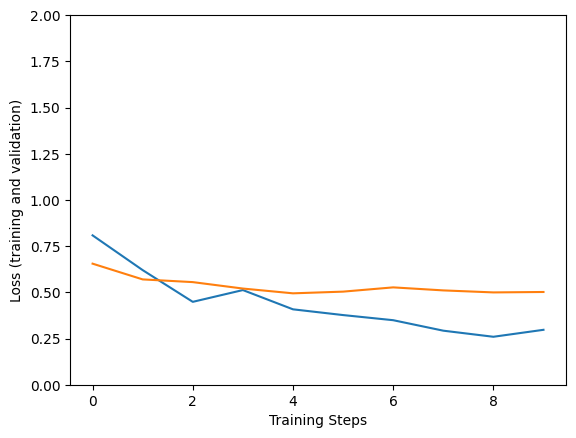

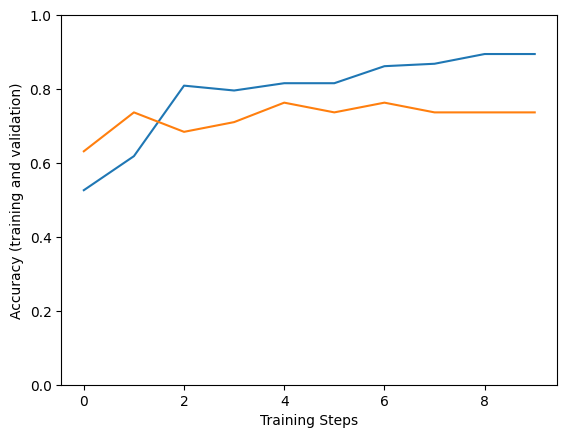

In [16]:

# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])


**Exporting Model**

In [17]:

import tensorflow as tf
import keras
import tensorflow_hub as hub


In [18]:

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


Epoch 1/10
5/5 [==============================] - 1s 255ms/step - loss: 0.2403 - acc: 0.9013 - val_loss: 0.5055 - val_acc: 0.7368
Epoch 2/10
5/5 [==============================] - 1s 232ms/step - loss: 0.2501 - acc: 0.9013 - val_loss: 0.5201 - val_acc: 0.7105
Epoch 3/10
5/5 [==============================] - 1s 221ms/step - loss: 0.2656 - acc: 0.8816 - val_loss: 0.5200 - val_acc: 0.7105
Epoch 4/10
5/5 [==============================] - 1s 221ms/step - loss: 0.1984 - acc: 0.9211 - val_loss: 0.5327 - val_acc: 0.7105
Epoch 5/10
5/5 [==============================] - 1s 239ms/step - loss: 0.2208 - acc: 0.9342 - val_loss: 0.5270 - val_acc: 0.7105
Epoch 6/10
5/5 [==============================] - 1s 223ms/step - loss: 0.1851 - acc: 0.9276 - val_loss: 0.5232 - val_acc: 0.7105
Epoch 7/10
5/5 [==============================] - 1s 233ms/step - loss: 0.1920 - acc: 0.9408 - val_loss: 0.5192 - val_acc: 0.7368
Epoch 8/10
5/5 [==============================] - 1s 306ms/step - loss: 0.1876 - acc: 0.93

In [19]:

from tensorflow import keras


In [20]:

SMOKE_SAVED_MODEL = "/content/drive/My Drive/ZavrsniRad/saved_models/smoke"
model.save(SMOKE_SAVED_MODEL)
smoke_model = keras.models.load_model(SMOKE_SAVED_MODEL)

In [21]:

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)


Validation batch shape: (32, 224, 224, 3)


**Testing Our Model**

In [23]:

import pandas as pd


In [24]:

tf_model_predictions = smoke_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()


1/1 [==============================] - 1s 545ms/step
Prediction results for the first elements


,No_Smoke,Smoke
0,0.80099499,0.19900499
1,0.37592763,0.62407243
2,0.50960195,0.49039805
3,0.96494830,0.03505175
4,0.83154076,0.16845930


In [25]:

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]


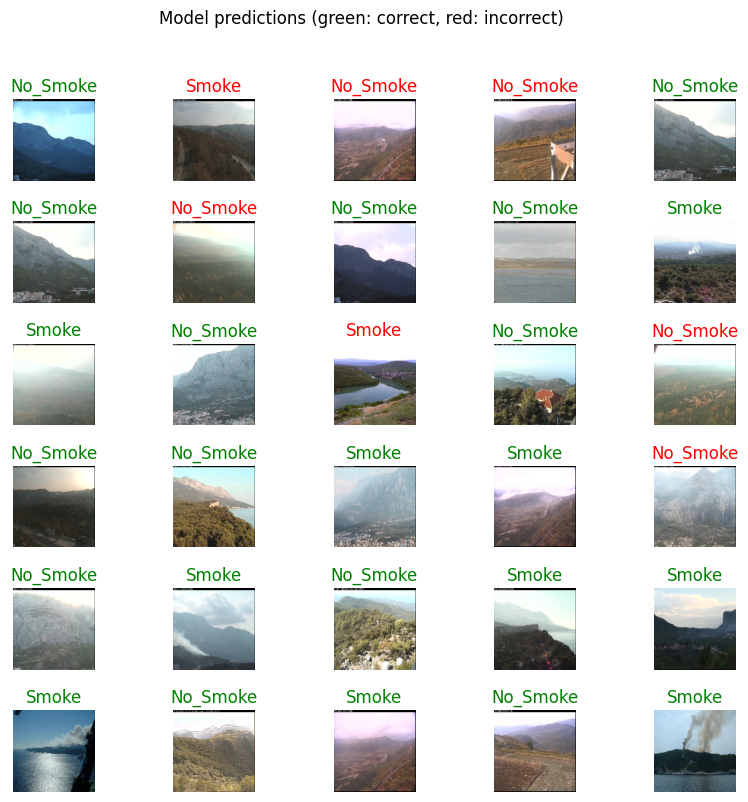

In [26]:

# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")



**Convert the model to TFLite**

In [27]:

TFLITE_MODEL = "/content/drive/My Drive/ZavrsniRad/tflite_models/smoke.tflite"

TFLITE_QUANT_MODEL = "/content/drive/My Drive/ZavrsniRad/tflite_models/smoke_quant.tflite"


In [28]:

import tensorflow as tf
import keras


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : smoke_model(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "/content/drive/My Drive/ZavrsniRad/tflite_models" -lh


TFLite models and their sizes:
total 22M
-rw------- 1 root root 2.5M May 30 15:06 shoe_quant.tflite
-rw------- 1 root root 8.6M May 30 15:06 shoe.tflite
-rw------- 1 root root 2.5M Aug 30 16:31 smoke_quant.tflite
-rw------- 1 root root 8.6M Aug 30 16:31 smoke.tflite
